# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Подготовка данных

In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

import lightgbm

from lightgbm import LGBMRegressor

In [3]:
try:
    data_arc = pd.read_csv('/Users/admin/Desktop/final_project/data_arc_new.csv',  parse_dates=[1,2]) 
    # данные об электродах
    
    data_bulk = pd.read_csv('/Users/admin/Desktop/final_project/data_bulk_new.csv') 
    # данные о подаче сыпучих материалов (объём)
    
    data_bulk_time = pd.read_csv('/Users/admin/Desktop/final_project/data_bulk_time_new.csv')
    # данные о подаче сыпучих материалов (время)
    
    data_gas = pd.read_csv('/Users/admin/Desktop/final_project/data_gas_new.csv')
    # данные о продувке сплава газом
    
    data_temp = pd.read_csv('/Users/admin/Desktop/final_project/data_temp_new.csv',  parse_dates=[1])
    # результаты измерения температуры
    
    data_wire = pd.read_csv('/Users/admin/Desktop/final_project/data_wire_new.csv')
    # данные о проволочных материалах (объём)
    
    data_wire_time = pd.read_csv('/Users/admin/Desktop/final_project/data_wire_time_new.csv')
    # данные о проволочных материалах (время)
    
    
except:

    data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1,2])
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

**Введение**

В данной задаче необхожимо предсказать температуру выпуска металла после цикла обработки в дуговой сталеплавильной печи. Цикл включает в себя такие операции как: нагрев шихты электродами, измерение температуры, подача сыпучих материалов, подача проволочных материалов, продувка инертным газом. По каждой операции предоставлен отдельные наборы данных об результатах выполнения операции и времени выполнения операции и номера ковша(паритии) к которому относится операция. Единицей моделирования в данной задаче будет являться ковш(партия)

### **Данные о нагреве электродами**

In [4]:
# дата приведена к типу datetime при загрузке датафрейма
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
# Заменим названия столбцов
data_arc.rename(columns={'Начало нагрева дугой':'start_heating', 'Конец нагрева дугой':'end_heating',
                         'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'}, inplace=True)

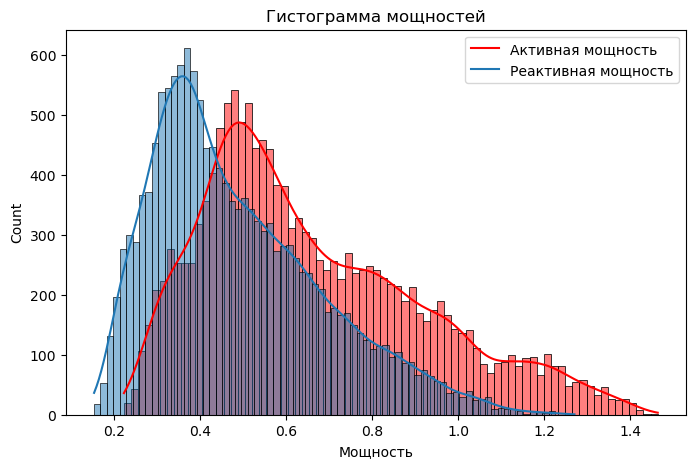

In [8]:
plt.figure(figsize=(8,5))

ax = sns.histplot(data_arc['active_power'].values, bins=75, kde=True, color='red')
ax = sns.histplot(data_arc['reactive_power'].loc[data_arc['reactive_power'] > -715].values, bins=75, kde=True)
ax.set_xlabel('Мощность')
ax.set_title('Гистограмма мощностей')
plt.legend(['Активная мощность','Реактивная мощность']);

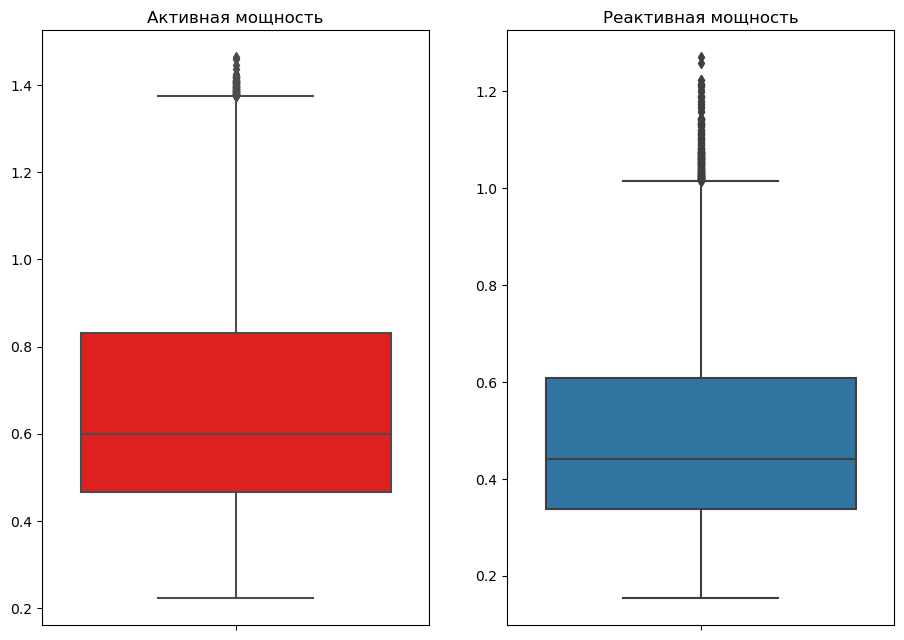

In [9]:
plt.figure(figsize=(11,17))

plt.subplot(2, 2, 1)
sns.boxplot(y=data_arc['active_power'].values, color='red')
plt.title('Активная мощность')

plt.subplot(2, 2, 2)
sns.boxplot(y=data_arc['reactive_power'].loc[data_arc['reactive_power'] > -715].values)
plt.title('Реактивная мощность')

plt.show();

In [10]:
print(f'Число партий {data_arc["key"].nunique()}')

Число партий 3214


**Обзор данных о нагреве электродами**
1. Представлены данные об активной и рекативной мощности для 3214 ковшей(партий) и время начала и конца нагрева. Всего 14876 циклов нагрева.
1. Распределения активной и реактивной мощности схожи - распределение смещено влево с хвостом в сторону возрастания.
1. На диаграме размаха видно что граница верхнего уса как у активной и реактивной мощности приходится на значение больше чем в два раза медианного. Так же присутсвуют выбросы за верхней границей.
1. Можно сделать предположение что значения выше 3 квартиля это и есть те перерасходы энергии, которые можно оптимизировать составим модель предсказания температуры выпуска металла.  

### **Данные о подаче сыпучих материалов**

In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [13]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


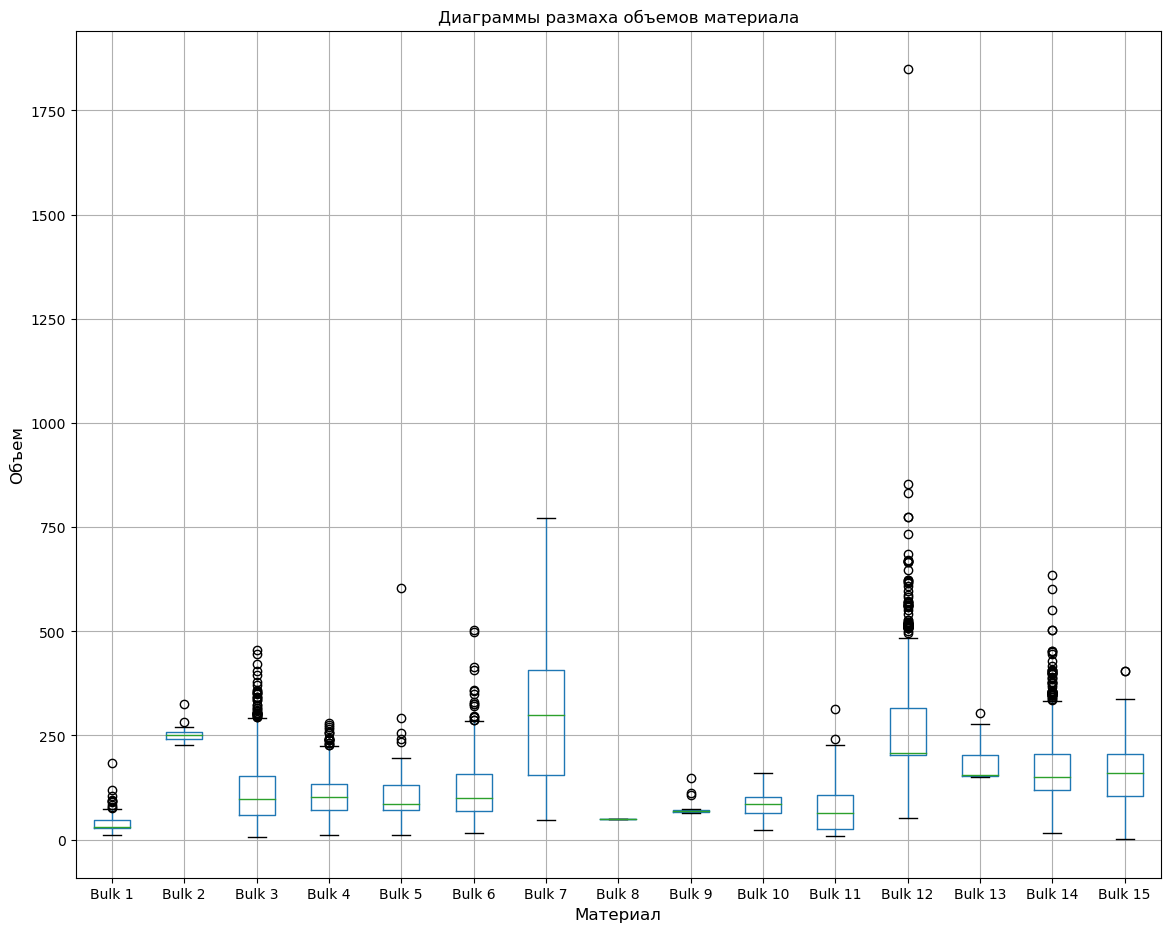

In [14]:
plt.figure(figsize=(14,11))

ax = data_bulk.loc[:,'Bulk 1':].boxplot()
ax.set_xlabel('Материал', fontsize=12)
ax.set_ylabel('Объем', fontsize=12)
ax.set_title('Диаграммы размаха объемов материала', fontsize=12);

In [15]:
# Подсчитаем число партий для каждого материала и создадим series
date_count = data_bulk.describe().loc['count', 'Bulk 1':].sort_values(ascending=False)

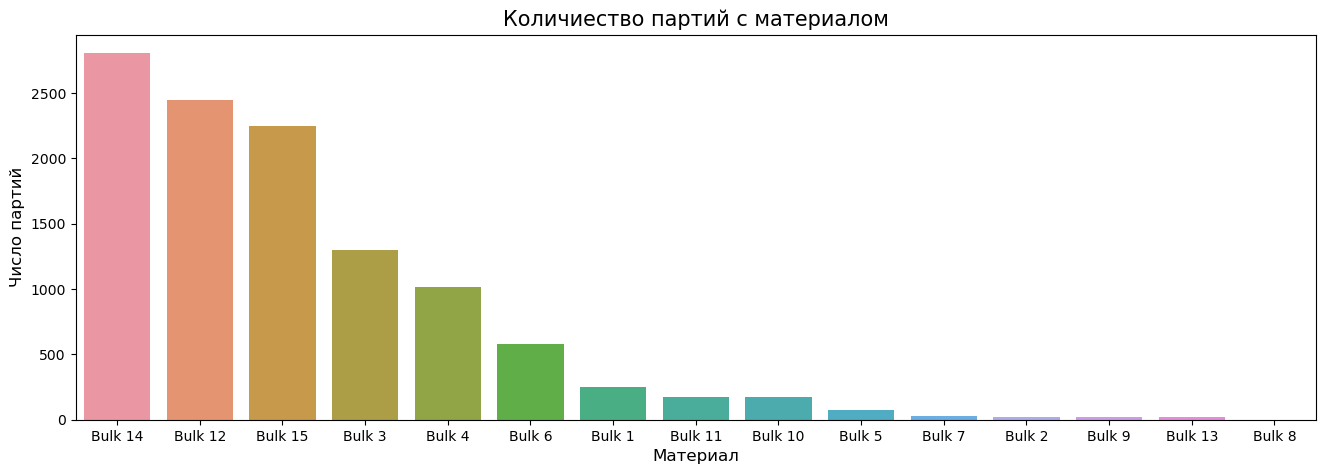

In [16]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Материал', fontsize=12)
ax.set_ylabel('Число партий', fontsize=12)
ax.set_title('Количиество партий с материалом', fontsize=15);

In [17]:
# Приведем столбцы со временем добавления материала к типу datetime
for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

In [18]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [19]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


**Обзор данных о подаче сыпучих материалов**
1. Данные предсталены двумя датафремами. 1- дане об объеме поданого материала, 2- данные о времени подачи материала
1. В каждом датафрейме есть номер партии к которой относится подача материала. Число партий 3129.
1. Всего 15 типов материалов. 3 из них (12,14,15) встречаются более чем в 2000 партий, еще 3 (3,4,6) от 500 до 1300 партий, остальные встреаются меньше чем в 300 партиях. Пропуски означают что в данной партии этот вид материала не подавался - объем равен 0.
1. Объем добавок распределен в диапазоне от 1 до 1849

### **Данные о проволочных материалах**

In [20]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [22]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


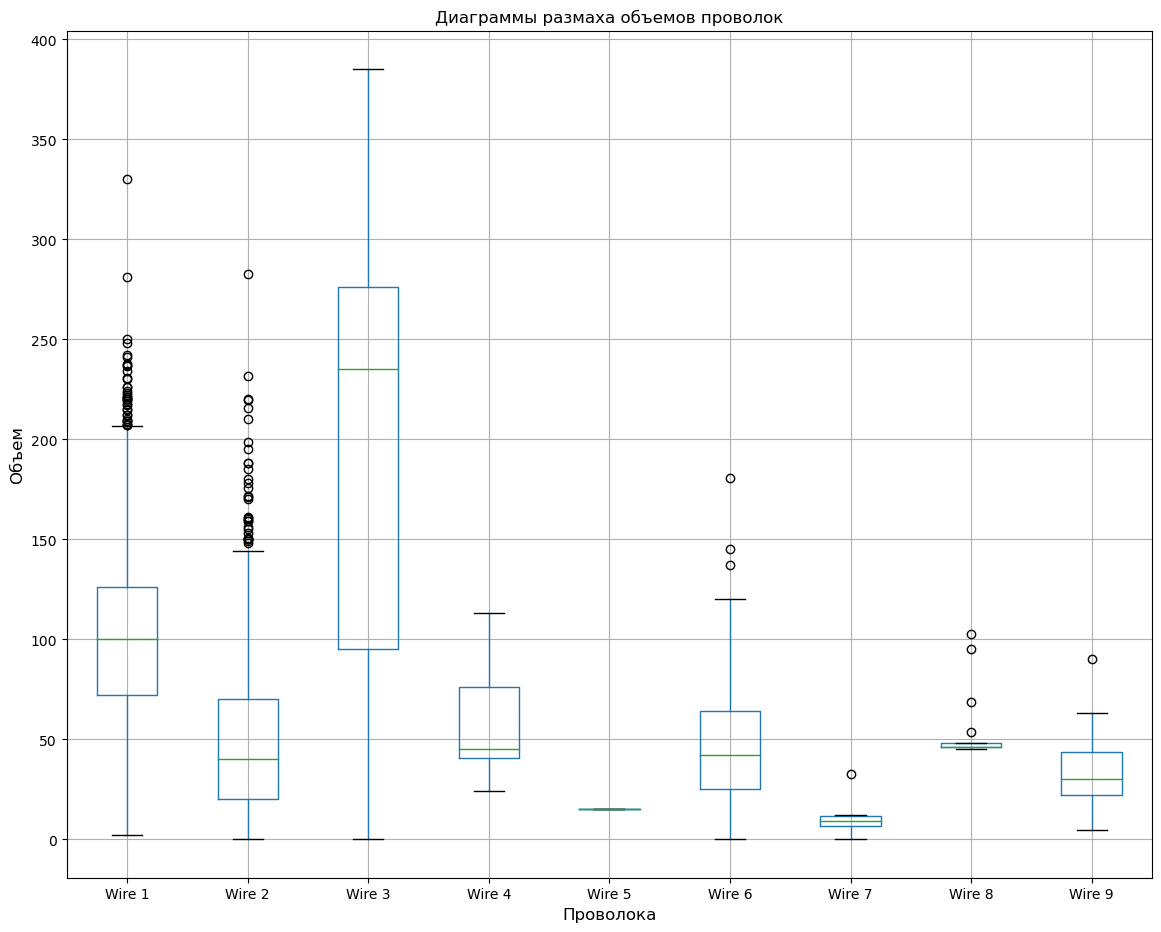

In [23]:
plt.figure(figsize=(14,11))

ax = data_wire.loc[:,'Wire 1':].boxplot()
ax.set_xlabel('Проволока', fontsize=12)
ax.set_ylabel('Объем', fontsize=12)
ax.set_title('Диаграммы размаха объемов проволок', fontsize=12);

In [24]:
# Подсчитаем число партий для каждой проволоки и создадим series
date_count = data_wire.describe().loc['count', 'Wire 1':].sort_values(ascending=False)

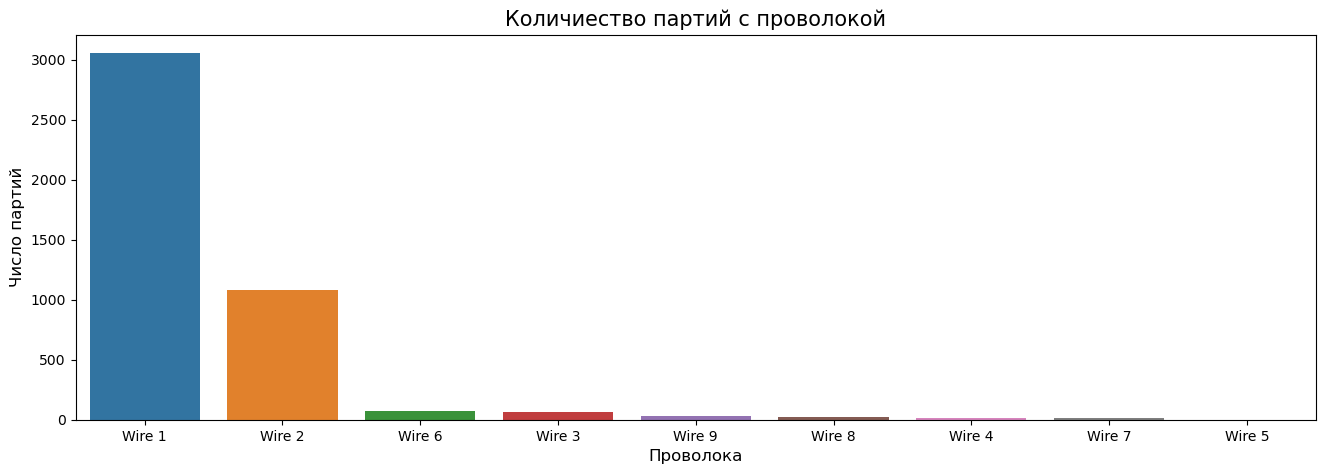

In [25]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Проволока', fontsize=12)
ax.set_ylabel('Число партий', fontsize=12)
ax.set_title('Количиество партий с проволокой', fontsize=15);

In [26]:
# Приведем столбцы со временем добавления проволоки к типу datetime
for col in data_wire_time.columns[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [27]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [28]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Обзор данных о проволочных материалах**
1. Данные предсталены двумя датафреймами. 1- дане об объеме проволочных материалах, 2- данные о времени подачи проволочных материалов
1. В каждом датафрейме есть номер партии к которой относится подача материала. Число партий 3081.
1. Всего 9 типов проволочных материалов. 1 из них (1) встречаются более чем в 3000 партий, еще 1 (2) в 1000 партий, остальные встреаются меньше чем в 100 партиях. Пропуски означают что в данной партии этот вид материала не подавался - объем равен 0.
1. Объем добавок распределен в диапазоне от 0.03 до 385

### **Данные о продувке сплава газом**

In [29]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [30]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [31]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [32]:
# Заменим названия столбцов
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

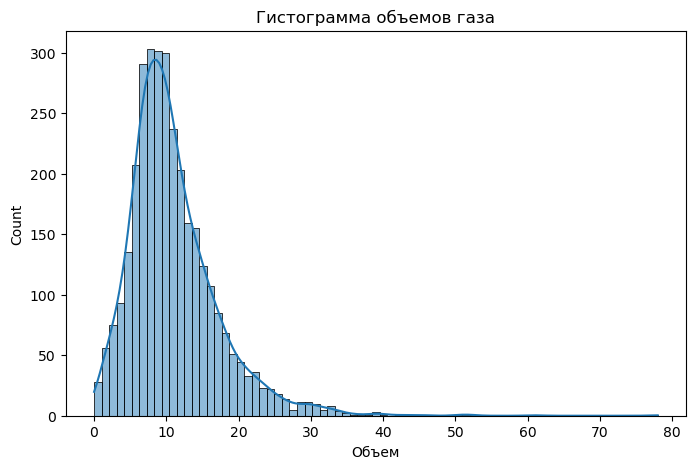

In [33]:
plt.figure(figsize=(8,5))

ax = sns.histplot(data_gas['gas'].values, bins=75, kde=True)
ax.set_xlabel('Объем')
ax.set_title('Гистограмма объемов газа');

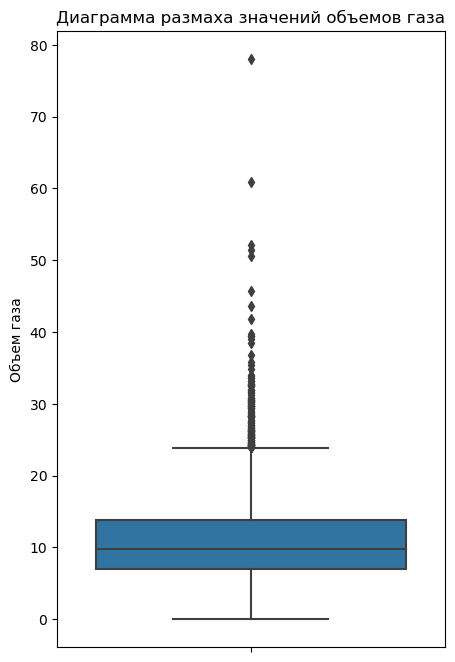

In [34]:
plt.figure(figsize=(5,8))

sns.boxplot(y=data_gas['gas'].values)
plt.ylabel('Объем газа')
plt.title('Диаграмма размаха значений объемов газа');

**Обзор данных о продувке сплава газом**
1. Представлены данные о продувке сплава газом для 3239 ковша(партии) и время начала и конца нагрева.
1. Распределения объема газа смещено влево с хвостом в сторону возрастания.
1. На диаграме размаха видно что значения в ящике находятся в диапазоне между 7 и 14, но так же присутствует достаочно выбросов до 80.
1. Возможно большой объем использованного газа характерен для партий с большим расходом энергии, поскольку вместе с нагревом шихту перемешивают.  

### **Данные о результатах измерения температуры**

In [35]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [36]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [37]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [38]:
# Заменим названия столбцов
data_temp = data_temp.rename(columns={'Время замера':'msrmnt_time','Температура':'temp'})

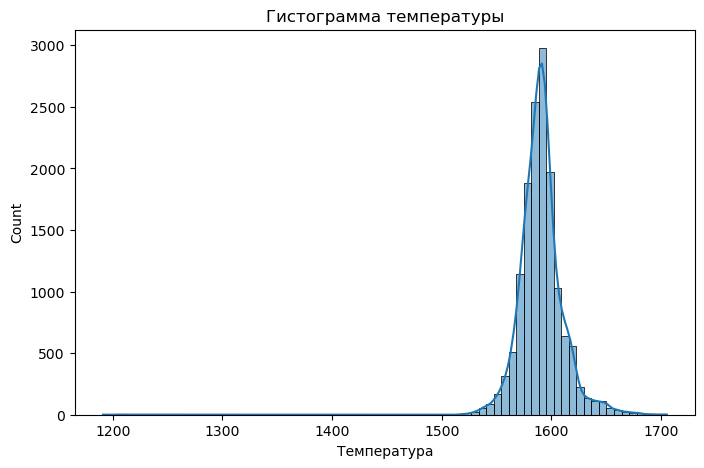

In [39]:
plt.figure(figsize=(8,5))

ax = sns.histplot(data_temp['temp'].values, bins=75, kde=True)
ax.set_xlabel('Температура')
ax.set_title('Гистограмма температуры');

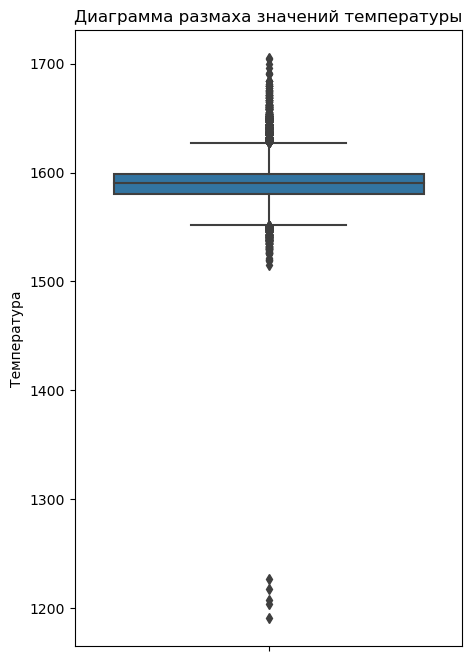

In [40]:
plt.figure(figsize=(5,8))

sns.boxplot(y=data_temp['temp'].values)
plt.ylabel('Температура')
plt.title('Диаграмма размаха значений температуры');

In [41]:
print(f'Число партий {data_temp["key"].nunique()}')

Число партий 3216


**Обзор данных о результатах измерения температуры**
1. Представлены данные об о результатах измерения температуры для 3216 ковша(партии) и время начала и конца нагрева. Всего 18092 замеров, при этом 14665 содержат значение температуры (не пропуски).
1. Распределения температуры нормальное, квартили находятся в сравнительно небольшом диапазоне 20 градусов от 1580 до 1599.
1. Верхние значения выбросов доходят до 1705 градусов, нижние до 1500, при это есть значения ниже 1250 градусов, партии в которых присутствуют эти значения в данной работе исследоваьтся не будут.

**Вывод**
1. Данные представлены 7 датафреймами, они содержат данные о нагреве электродами, подаче сыпучих материалов(объем и время), проволочных материалах (объем и время), данные о продувке газом и данные о замере температуры
1. Каждый набор данных содержит ключ с номером партии к которому относятся данные
1. Всего предоставленно данных о партиях с номерами 1 до 3241. В данном наборе представленные не все номера партий, некоторые партии имеют пропуски в целевой переменной, аномальные значения не позволющие использовать их для обучения и проверки модели

In [42]:
# Удалим переменную
del date_count

## **План решения задачи**

1. Предобработка данных:

    1. Удаление партий с явно авномальными значениями 
    1. Заполнение пропусков в таблицах подачи проволочных и сыпучих материалов нулевым значением
    1. Генерация новых признаков
    1. Агрегирование по ключу значений мощности(суммарное значения активной и суммарное значение реактивной мощности для партии)
    1. Агрегирование начальной температуры и конечной температуры

1. Объединение в один датафрейм по номеру партии(ключу)
    1. Отбор только партий с данными о температуре
    1. Где измерение температуры первая и последняя операция цикле

1. Исследование объединенного датафрейма
    1. Исследование зависмости признаков и целевой переменной
    1. Построение хитмап
    1. Предобработка полученного датафрема
    
1. Выбор модели
    1. Выделение тестовой выборки
    1. Получение метрики на кросс-валидации и подбор гиперпараметров
    1. Выбор модели с лучшей метрикой

1. Получение результа
    1. Получение результата на тестовой выборке
    1. Исследование важности признаков
    1. Общий выводы 

## **Предобработка данных**

### **Предобработка исходных данных**

#### **Предобработка данных о нагреве электродами**

In [43]:
# Создадим признак - продолжительность нагрева в минутах

data_arc['heating_duration'] = (data_arc['end_heating'] - data_arc['start_heating']) / pd.Timedelta(minutes=1)

In [44]:
# Агрегируем значения о нагреве электродами по номеру партии - значения активной мощности, реактивной мощности 
# и продолжительности нагрева просуммируем, отдельно запишем время окончнания последней операции нагрева

data_arc_total = data_arc.groupby('key').agg({'end_heating':'last' ,'active_power':'sum', \
                             'reactive_power':'sum', 'heating_duration':'sum'})

Создадим признак полной мощности

$S = \sqrt{P^2 + Q^2}$ - полная мощность, где P - активная мощность, Q - реактивная мощность

In [45]:
# Добавим признак полной мощности
data_arc_total['sum_power'] = np.sqrt((data_arc_total['active_power'])**2 + (data_arc_total['reactive_power'])**2)
data_arc_total

,end_heating,active_power,reactive_power,heating_duration,sum_power
key,,,,,
1,2019-05-03 11:28:37,3.036730,2.142821,18.300000,3.716640
2,2019-05-03 11:53:18,2.139408,1.453357,13.516667,2.586371
3,2019-05-03 12:32:19,4.063641,2.937457,10.916667,5.014163
4,2019-05-03 12:57:50,2.706489,2.056992,12.350000,3.399456
5,2019-05-03 13:33:55,2.252950,1.687991,14.483333,2.815155
...,...,...,...,...,...
3237,2019-09-06 11:53:55,2.541872,2.025417,15.150000,3.250143
3238,2019-09-06 12:31:35,1.374821,1.038103,9.100000,1.722728
3239,2019-09-06 15:05:50,4.848005,3.541541,20.266667,6.003804


In [46]:
# Удалим партию с выбросом в значении реактивной мощности
data_arc_total = data_arc_total.loc[data_arc_total['reactive_power']>-5]
print(f'Итого значений в таблице {data_arc_total.shape[0]}')

Итого значений в таблице 3213


#### **Создание признкака по типу добавок**

In [47]:
# Заменим в данных о подаче сыпучих материалов индекс на номер партии 
data_bulk.set_index('key', inplace=True)

In [48]:
# Заменим в данных о проволочных материалах индекс на номер партии
data_wire.set_index('key', inplace=True)

#### **Предобработка данных о подаче сыпучих материалов**

In [49]:
# Заполним пропуски 0
data_bulk = data_bulk.fillna(0)

In [50]:
# Добавим признак времени последней операции загрузки матеаила в партии
data_bulk_time.set_index('key', inplace=True)
data_bulk['bulk_time'] = data_bulk_time.max(axis=1)

#### **Предобработка данных о проволочных материалах**

In [51]:
# Заполним пропуски 0
data_wire = data_wire.fillna(0)

In [52]:
# Добавим признак времени последней операции загрузки проволоки в партии
data_wire_time.set_index('key', inplace=True)
data_wire['wire_time'] = data_wire_time.max(axis=1)

#### **Предобработка данных о продувке сплава газом**

In [53]:
# Заменим в данных о продувке сплава газом индекс на номер партии
data_gas.set_index('key', inplace=True)

#### **Предобработка данных о результатах измерения температуры**

In [54]:
# Для признкак температуры создадим датафреймы которые будут включать первое и последнее измерение температуры и врмемя измеиерения

data_temp_first = data_temp.groupby('key').nth(0) \
                    .rename(columns={'msrmnt_time':'msrmnt_time_first', 'temp':'temp_first'})

data_temp_last = data_temp.groupby('key').nth(-1) \
                    .rename(columns={'msrmnt_time':'msrmnt_time_last', 'temp':'temp_last'})

In [55]:
# Данные объединим и удалим те партии где есть пропуск в данных
data_temp_total = pd.concat([data_temp_first, data_temp_last], axis=1).dropna()
data_temp_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   msrmnt_time_first  2477 non-null   datetime64[ns]
 1   temp_first         2477 non-null   float64       
 2   msrmnt_time_last   2477 non-null   datetime64[ns]
 3   temp_last          2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.8 KB


In [56]:
# Удалим партии с одним замером температуры
data_temp_total = data_temp_total.loc[data_temp_total['msrmnt_time_first'] != data_temp_total['msrmnt_time_last']]

In [57]:
# Удалим партии с аномальными значениями температуры
data_temp_total = data_temp_total.loc[(data_temp_total['temp_first'] > 1350) & (data_temp_total['temp_last'] > 1350)]
print(f'Итого значений в таблице {data_temp_total.shape[0]}')

Итого значений в таблице 2471


### **Объединение данных и предобработка**

#### **Объединение данных**

In [58]:
# Объединим все датафреймах так, что бы в итоговый датафрейм попали только те партии, которые есть во всех датафреймах
data_total = pd.concat([data_temp_total, data_arc_total, data_bulk, data_wire, data_gas], \
                       join='inner', axis=1).sort_index()

In [59]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   msrmnt_time_first  2324 non-null   datetime64[ns]
 1   temp_first         2324 non-null   float64       
 2   msrmnt_time_last   2324 non-null   datetime64[ns]
 3   temp_last          2324 non-null   float64       
 4   end_heating        2324 non-null   datetime64[ns]
 5   active_power       2324 non-null   float64       
 6   reactive_power     2324 non-null   float64       
 7   heating_duration   2324 non-null   float64       
 8   sum_power          2324 non-null   float64       
 9   Bulk 1             2324 non-null   float64       
 10  Bulk 2             2324 non-null   float64       
 11  Bulk 3             2324 non-null   float64       
 12  Bulk 4             2324 non-null   float64       
 13  Bulk 5             2324 non-null   float64       
 14  Bulk 6  

Полученная таблица содержит 36 столбцов

In [60]:
# Проверим что все замеры температуры являются начальным и конечным действием в своей партии

time_cols = ['end_heating', 'bulk_time', 'wire_time']

for col in time_cols:

    print((data_total['msrmnt_time_first'] > data_total[col]).sum(),
    (data_total['msrmnt_time_last'] < data_total[col]).sum())

0 0
0 0
0 0


Замеры температуры выбраны верно

#### **Предобработка итогового датафрейма**

In [61]:
# Удалим столбцы с данными о времени операции в цикле
data_total.drop(['end_heating', 'bulk_time', 'wire_time', 'msrmnt_time_first', 'msrmnt_time_last'], axis=1, inplace=True)

In [62]:
# Удалим партии где нет данных об нагреве электродами
data_total.dropna(subset=['active_power'], inplace=True)

In [63]:
# Пропуски в остальных признаках заполним 0
data_total.fillna(0, inplace=True)

In [64]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp_first        2324 non-null   float64
 1   temp_last         2324 non-null   float64
 2   active_power      2324 non-null   float64
 3   reactive_power    2324 non-null   float64
 4   heating_duration  2324 non-null   float64
 5   sum_power         2324 non-null   float64
 6   Bulk 1            2324 non-null   float64
 7   Bulk 2            2324 non-null   float64
 8   Bulk 3            2324 non-null   float64
 9   Bulk 4            2324 non-null   float64
 10  Bulk 5            2324 non-null   float64
 11  Bulk 6            2324 non-null   float64
 12  Bulk 7            2324 non-null   float64
 13  Bulk 8            2324 non-null   float64
 14  Bulk 9            2324 non-null   float64
 15  Bulk 10           2324 non-null   float64
 16  Bulk 11           2324 non-null   float64


In [65]:
data_total.describe()

,temp_first,temp_last,active_power,reactive_power,heating_duration,sum_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1587.368761,1593.372633,3.126327,2.301280,13.469944,3.882991,3.435026,1.425559,47.317126,37.347676,...,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,11.378854
std,23.627590,11.207457,1.220484,0.903711,5.680230,1.516067,12.424463,19.102530,75.238050,58.677890,...,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,6.397008
min,1519.000000,1541.000000,0.267676,0.196228,0.950000,0.331897,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399
25%,1571.000000,1587.000000,2.295960,1.671099,9.683333,2.842446,0.000000,0.000000,0.000000,0.000000,...,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534
50%,1587.000000,1593.000000,3.036517,2.225900,12.966667,3.767364,0.000000,0.000000,0.000000,0.000000,...,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687
75%,1603.000000,1598.000000,3.834302,2.829179,16.550000,4.767398,0.000000,0.000000,80.000000,77.250000,...,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.218487
max,1660.000000,1653.000000,12.375636,8.949049,69.816667,15.272257,185.000000,325.000000,454.000000,281.000000,...,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040


In [66]:
data_total

,temp_first,temp_last,active_power,reactive_power,heating_duration,sum_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,3.036730,2.142821,18.300000,3.716640,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,2.139408,1.453357,13.516667,2.586371,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,4.063641,2.937457,10.916667,5.014163,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,2.706489,2.056992,12.350000,3.399456,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,2.252950,1.687991,14.483333,2.815155,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.168133,2.210936,12.050000,3.863328,0.0,0.0,21.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,4.174918,2.872031,15.666667,5.067396,0.0,0.0,0.0,63.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,3.605239,2.452092,9.483333,4.360104,0.0,0.0,0.0,85.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


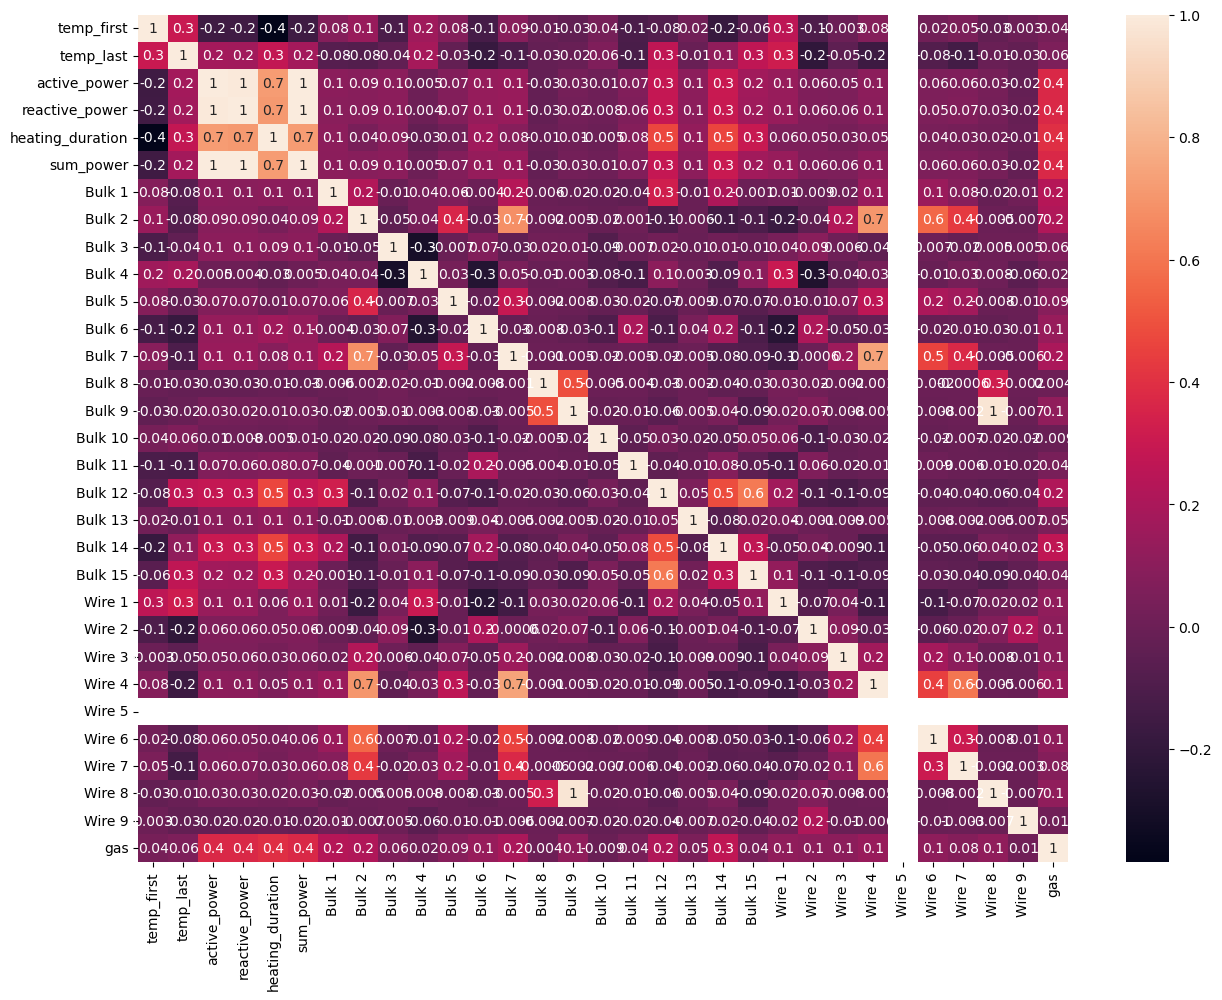

In [67]:
plt.figure(figsize=(15,11))

sns.heatmap(data_total.corr(), annot = True, fmt='.1g');

**Вывод**
1. В итоговый датафрем вошел 31 признак и данные о 2324 партиях.
1. На хитмап видно что наибольшая корреляция у целевого признака с начальной температурой, так же есть корреляции между отдельными признаками
1. По номерам ключей(партий) можно заметить что последний номер партии 2499, ни одна более 700 партии после этого номера не вошли в конечный набор данных, это свидетельствует об ошибке на этапе сбора данных
1. Некоторые признаки, такие как отдельные типы добавок содержатся в малом числе партий или не содержаться совсем, поэтому их влияение на целевую переменную может быть оценено неверно
1. В данных присутствуют коллинеарные признаки (корреляция равна 1): 1 - это энергия на электродах (active_power, reactive_power, sum_power), 2 - обьемы материала Bulk 9 и проволоки Wire 8

## **Разработка модели**

### **Подготовка признаков**

In [68]:
# Выделим целевой признак
features = data_total.drop('temp_last', axis=1)
target = data_total['temp_last']

In [69]:
# Разделим выборки на тренировочную и тестовую, тестовая выборка 0.25 от общей
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size = 0.25, random_state=20623)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1743, 30)
(1743,)
(581, 30)
(581,)


In [70]:
# Создадим скейлер и масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

In [71]:
features_train_scaled = pd.DataFrame(scaler.transform(features_train), 
                                 columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(scaler.transform(features_test), 
                                 columns=features_test.columns, index=features_test.index)

### **Выбор модели**

Для тестирования выбраны три модели:
1. Линейная регрессия
1. Случайный лес
1. LightGBM

#### **LinearRegression**

In [72]:
# Для обучения модели LinearRegression удалим из выборки коллинеарные признкаи
features_train_nc = features_train_scaled.drop(['reactive_power', 'sum_power', 'Wire 8'], axis=1)

In [73]:
model = LinearRegression()
mae_LR = (-cross_val_score(model, features_train_nc, target_train ,cv=5, scoring='neg_mean_absolute_error')).mean()

print('Результаты для модели LinearRegression')
print('MAE на кросс-валидации: %.2f' % (mae_LR).mean())

Результаты для модели LinearRegression
MAE на кросс-валидации: 6.77


#### **RandomForestRegressor**

In [ ]:
model = RandomForestRegressor(random_state=20623)
parametrs = {
             'n_estimators': [500, 700, 1000], 
             'max_depth': [1, 5, 10], 
             'min_samples_split': [2, 3, 5]
}

grid = GridSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error',  n_jobs=-1, verbose=1)

grid.fit(features_train_scaled, target_train)
mae_RFR = -grid.best_score_

print()
print('Результаты для модели RandomForestRegressor')
print('Гиперпараметры для модели RandomForestRegressor:', grid.best_params_)
print('MAE: %.2f' % (mae_RFR))

#### **LGBMRegressor**

In [75]:
model = LGBMRegressor(random_state=20623)
parametrs = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}
grid = GridSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error',  n_jobs=-1, verbose=1)

grid.fit(features_train_scaled, target_train)
mae_LGBM = -grid.best_score_

print()
print('Результаты для модели LGBMRegressor')
print('Гиперпараметры для модели LGBMRegressor:', grid.best_params_)
print('MAE: %.2f' % (mae_LGBM))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Результаты для модели LGBMRegressor
Гиперпараметры для модели LGBMRegressor: {'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28}
MAE: 6.27


**Итог**\
Наилучий результат метрики MAE = 6.27 получен на модели LGBMRegressor

### **Проверка качества лучшей модели**

Проверим качество модели LGBMRegressor на тестовой выборке

In [76]:
# Создадим модель с наилучшими гиперпараметрами полученными на кросс валидации
lgbm_tuned = grid.best_estimator_

# Получим предсказание модели на тестовых признаках
predicted_test = lgbm_tuned.predict(features_test_scaled)

# Получим значение метрики MAE
mae = mean_absolute_error(target_test, predicted_test)
print('MAE: %.2f' % (mae))

MAE: 5.99


Значение метрики MAE = 5.99 меньше требуемой 6.8 - модель работает успешно

### **Оценка важности признаков**

In [77]:
# Создадим датафрейм с оценкой важности признаков и наименованием признака
feature_importances = pd.DataFrame({'value':lgbm_tuned.feature_importances_, 'feature':list(features.columns)})

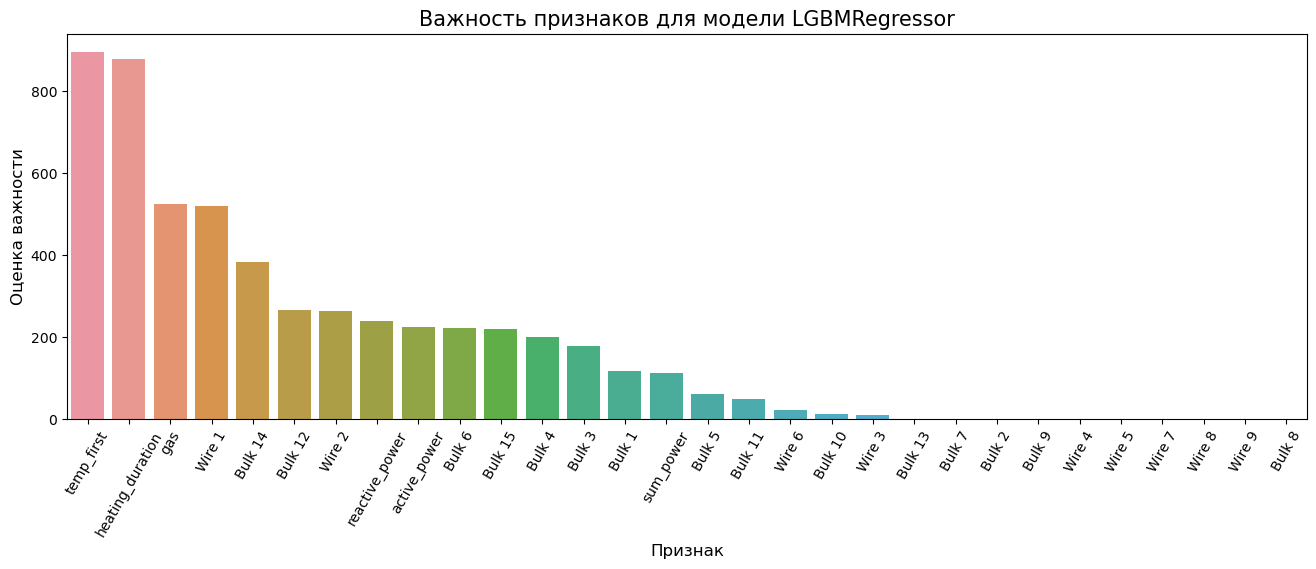

In [78]:
plt.figure(figsize=(16,5))

ax = sns.barplot(y='value', x='feature', 
                 data=feature_importances.sort_values(by='value', ascending=False))
ax.set_xlabel('Признак', fontsize=12)
ax.set_ylabel('Оценка важности', fontsize=12)
ax.set_title('Важность признаков для модели LGBMRegressor', fontsize=15)
plt.xticks(rotation=60);

Оценка важности признаков показала: 
1. Наиболее важными признаками для предсказания температуры выпуска стали из ковша являются начальная температура(temp_first) и суммарная продолжительность нагрева электродами (heating_duration) - оценка важности > 800, следующие по важности объем газа для перемешивания плавки(gas) и объем проволки 1 (Wire 1) > 500
1. Признаки характеризующие энергию имеют значимость ниже 300
1. Признаки некоторых добавок имеют почти нулевую значимость

### **Вывод**

1. Для обучения моделей была подготовлена итоговая выборка состоящая из 2324 строк и 31 признака
1. Из выборки был выделен целевой признак - температура выпуска стали. Выборка была разделена на обучающую и тестовую в соотношении 1:3
1. Признаки были мастабированы с помощью StandardScaler
1. Для тестирования выбраны три модели:
    1. Линейная регрессия
    1. Случайный лес
    1. LightGBM
1. Все модели показали на валидационной выборке значение MAE меньше требуемой 6.8
1. Наилучший результат на валидации получен на модели LightGBM - MAE = 6.27, модель была выбрана для оценки на тестовой выборке
1. Значение целевой метрики MAE = 5.99 меньше требуемой 6.8 - модель работает успешно
1. Оценка важности признаков показала:
    1. Наиболее важными признаками для предсказания температуры выпуска стали из ковша являются начальная температура(temp_first) и суммарная продолжительность нагрева электродами (heating_duration) - оценка важности > 800
    1. Следующие по важности объем газа для перемешивания плавки(gas) и объем проволки 1 (Wire 1) > 500
    1. Признаки характеризующие энергию имеют значимость ниже 300
    1. Признаки некоторых добавок имеют почти нулевую значимость

## **Отчет**

### **Введение**

В данном отчете представленны результаты работ разработке по прототипа модели машинного обучения для задачи предсказания температуры выпуска стали при ее плавлении в дуговой сталеплавильной печи. В отчете представлен обзор данных исплоьзованных для создания модели, план и ход работ, результаты работ, выводы и рекомендации основанные на полученном результате.

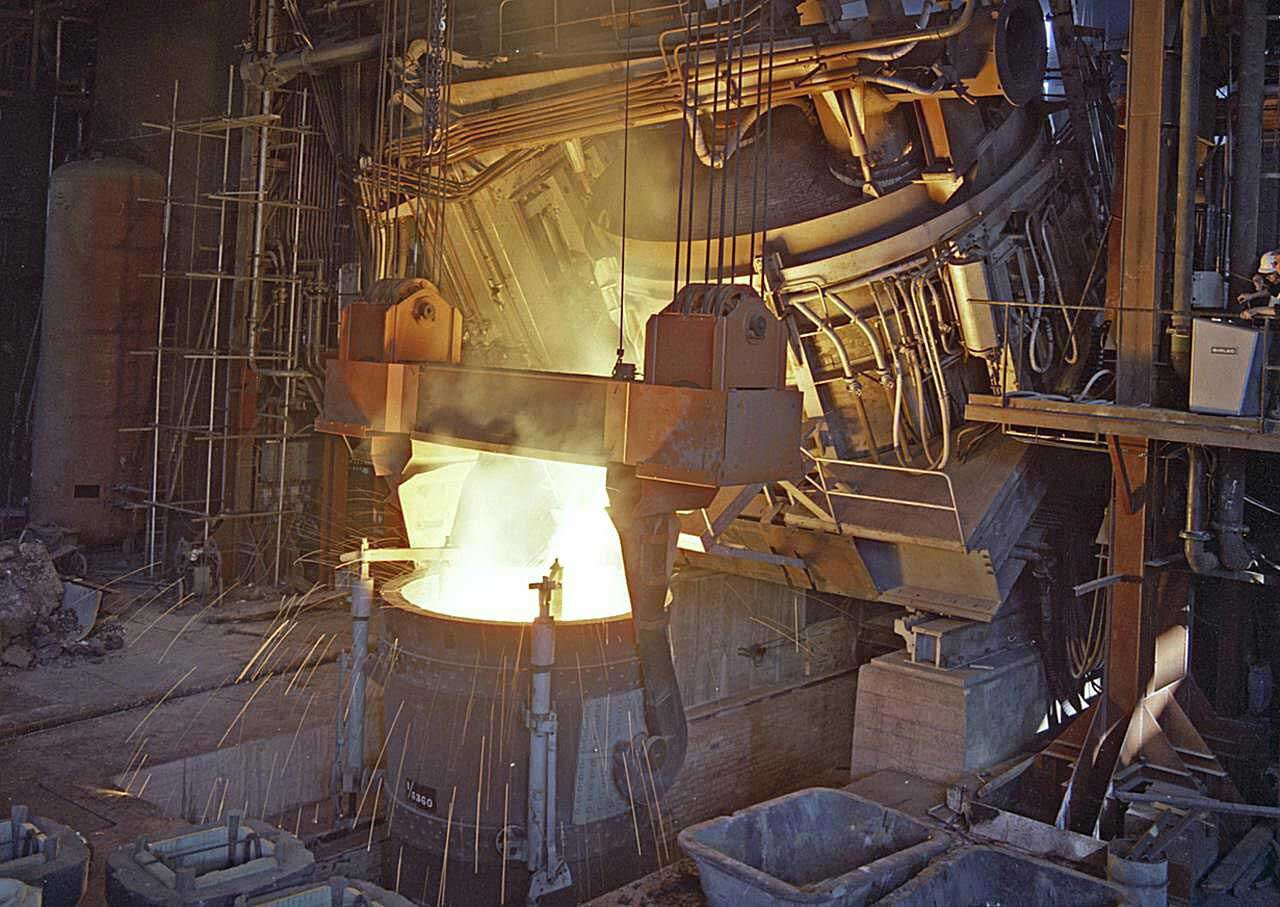

#### **Тема работы**

**Промышленность — задача проекта**\
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

#### **Проблематика работы**

В работе предстоит решить проблему определения температуры выпуска готовой стали из ковша. Единицей моделирования в работе является ковш или партия. Ковш(партия) имеет начальные параметр температуры и конечный(целевой) параметр температуры, данные об операциях в цикле (добавление легирующих добавок(сыпучих материалов или проволоки), продувание инертным газом.

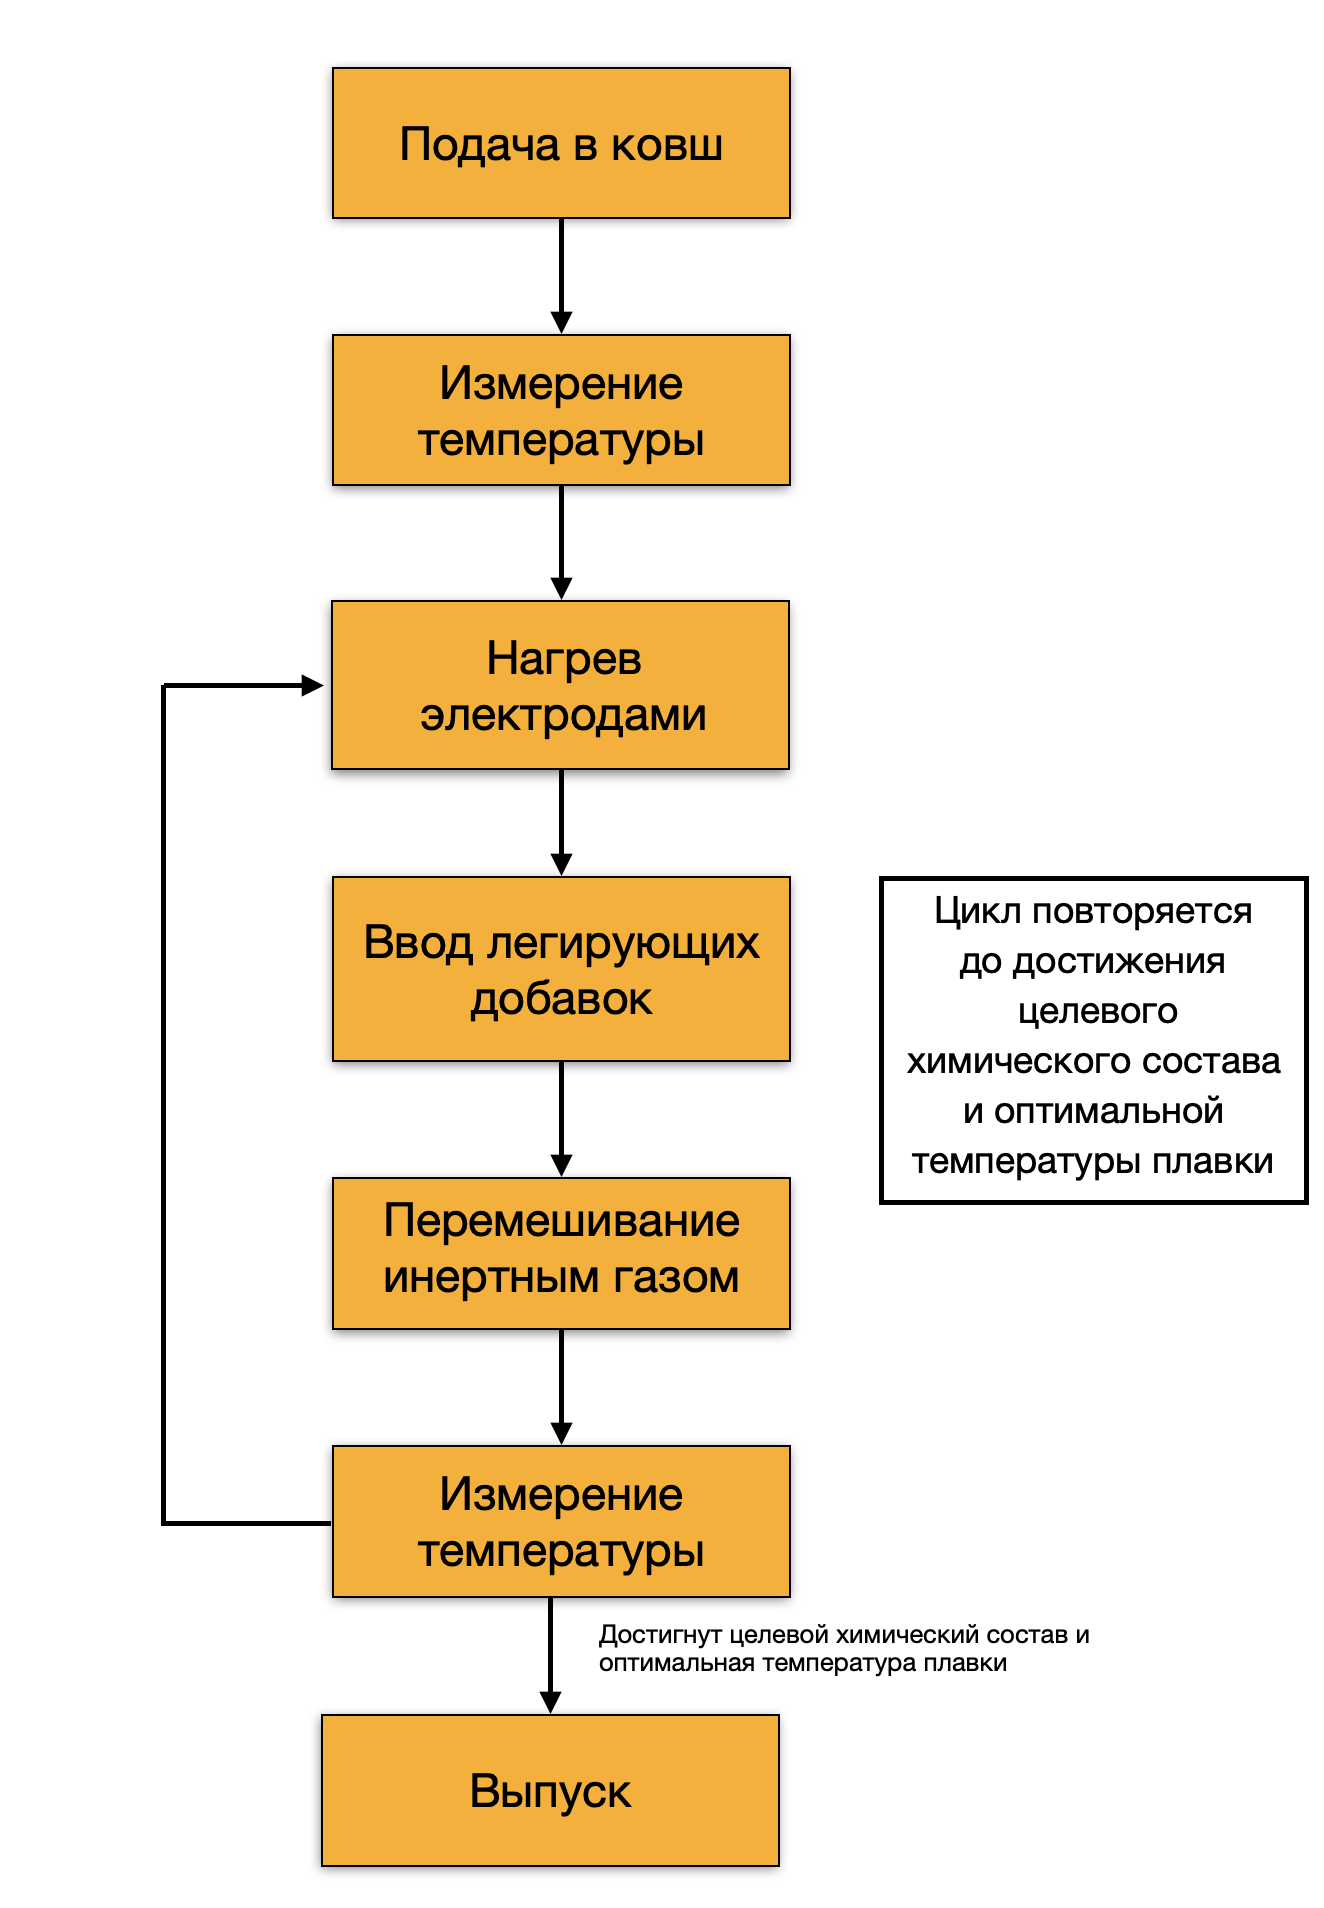

### **Данные**

#### **Состав данных**

Полученные данные представленны 7 датафреймами:  данные об электродах, данные о подаче сыпучих материалов (объём), данные о подаче сыпучих материалов (время), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём), данные о проволочных материалах (время)

#### **Содержание данных**

Каждый набор данных содержит ключ с номером партии к которому относятся данные.\
Всего предоставленно данных о партиях с номерами 1 до 3241. В данном наборе представленные не все номера партий.

Содержание данных в датафреймах:
1. Данные об электродах - активня и реактивня энергии каждого нагрева и время начала и окончания нагрева
1. Данные о подаче сыпучих материалов (объём) - объем добавленного типа материала, всего 15 видов материалов для 1 партии
1. Данные о подаче сыпучих материалов (время) - время добавления типа материала для 1 партии
1. Данные о продувке сплава газом - объеме использованного газа 1 партии
1. Результаты измерения температуры - начальная, конечная и промежуточные температуры для 1 партии, время замера температуры  
1. Данные о проволочных материалах (объём) - объем добавленного типа проволоки, всего 9 видов материалов для 1 партии
1. Данные о проволочных материалах (время) - время добавления типа проволоки для 1 партии

#### **Обзор данных**

По каждому набору данных был выполнен обзор - выведена и проанализирована основная информаци, рассмотрены несколько первых значений, составлены графики распределения и диаграммы размаха

Все признаки являются численными

Анализ данных показал что данные содержат выбросы, аномальные значения и пропуски

### **План решения задачи**

Исходя из анализа полученных данных и цели работы был составлен план работы содержащий следующие пункты:


1. Предобработка данных:

    1. Удаление партий с явно авномальными значениями 
    1. Заполнение пропусков в таблицах подачи проволочных и сыпучих материалов нулевым значением
    1. Генерация новых признаков
    1. Агрегирование по ключу значений мощности(суммарное значения активной и суммарное значение реактивной мощности для партии)
    1. Агрегирование начальной температуры и конечной температуры

1. Объединение в один датафрейм по номеру партии(ключу)
    1. Отбор только партий с данными о температуре
    1. Где измерение температуры первая и последняя операция цикле

1. Исследование объединенного датафрейма
    1. Исследование зависмости признаков и целевой переменной
    1. Построение хитмап
    1. Предобработка полученного датафрема
    
1. Выбор модели
    1. Выделение тестовой выборки
    1. Получение метрики на кросс-валидации и подбор гиперпараметров
    1. Выбор модели с лучшей метрикой

1. Получение результа
    1. Получение результата на тестовой выборке
    1. Исследование важности признаков
    1. Общий выводы 

### **Ход решения задачи**

#### **Предобработка данных**

**Предобработка исходных данных**\
На этапе предобработки данных отдельных датафремах были выполнены следующие действия:
1. Созданы признаки:
    1. Времения нагрева шихты электродами - сумма разностей времени начала и конца нагревов для одного цикла
    1. Полной мощности $S = \sqrt{P^2 + Q^2}$ - полная мощность, где P - активная мощность, Q - реактивная мощность
    1. Признак характеризующий добавленные типы материалов и проволоки (не использовался для обучения модели)
    
    
2. Удалены данные об содержащие аномальные значения реактивной мощности (-715) и температуры (>1350)
3. Данные о температуре были объеденины по номеру партии и оставлены значения начальной и конечной температуры
4. Пропуски в датафреймах о сыпучих и проволочных материалах были заполнены 0, покольку пропуск означал что материал не подавался в этой партии
4. Составлены датафреймы содержащие информацию о времени последней оперции в цикле
5. Все датафреймы были проиндексированы по ключу партии

**Объединение данных**\
Далее все датафреймы были объеденины в один по номеру партии, в итоговый датафрейм вошли только партии представленные в каждом наборе данных.

Проведена конечная проверка что замеры температур являются первой и последней операцией в цикле, после чего данные о времени были удалены.


**Итоговый датафрейм**\
В итоговый датафрем вошел 31 признак и данные о 2324 партиях

Анализ хитмап показал что в данных присутствуют коллинеарные признаки (корреляция равна 1): 1 - это энергия на электродах (active_power, reactive_power, sum_power), 2 - обьемы материала Bulk 9 и проволоки Wire 8. 

Основной причиной удаления партий стало отсутствие данных о температуре в партиях после 2499, ни одна более 700 партии после этого номера не вошли в конечный набор данных, это свидетельствует об ошибке на этапе сбора данных

#### **Разработка модели**

**Подготовка признаков**\
Для обучения модели был выделен целевой признак, признаки были разделены на тренировочну и тестовую выборки в соотношении 1:3, признаки были масштабированы SatndardScaler

**Выбор модели**\
Для тестирования выбраны три модели:
1. Линейная регрессия
1. Случайный лес
1. LightGBM

**Кроссвалидация и подбор гиперпараметров**
1. Линейная регрессия
    1. Для обучения линейной регрессия из выборки были удалены коллинеарные признаки
    1. Для кросс валидации использовались следующие параметры: cv=5, scoring='neg_mean_absolute_error'
    1. Полученный результат МАЕ = 6.77
    
    
1. Случайный лес
    1. Подбор гиперпараметров и кросс-валидация осуществлялась с использованием GridSearchCV, 
    1. Подбирались следующие гиперпараметры: 'n_estimators': [500, 700, 1000], 'max_depth': [1, 5, 10], 'min_samples_split': [2, 3, 5]
    1. Для кросс валидации использовались следующие параметры: cv=5, scoring='neg_mean_absolute_error'
    1. Полученный результат MAE = 6.36
    
    
1. LightGBM
    1. Подбор гиперпараметров и кросс-валидация осуществлялась с использованием GridSearchCV, 
    1. Подбирались следующие гиперпараметры:     'num_leaves': [7, 14, 21, 28, 31, 50], 'learning_rate': [0.1, 0.03, 0.003], 'max_depth': [-1, 3, 5], 'n_estimators': [50, 100, 200, 500]
    1. Для кросс валидации использовались следующие параметры: cv=5, scoring='neg_mean_absolute_error'
    1. Полученный результат MAE = 6.27 
    1. Модель выбрана для проверке на тестовой выборке

**Проверка модели**\
Проверка на тестовой выборке проводилсаь на модели LightGBM с гиперпараметрами определенными на с помощью GridSearchCV на кросс-валидации.\
Значение метрики на тестовой выборке MAE = 5.99 меньше требуемой 6.8 - модель работает успешно

**Оценка важности признаков**

1. Наиболее важными признаками для предсказания температуры выпуска стали из ковша являются начальная температура(temp_first) и суммарная продолжительность нагрева электродами (heating_duration) - оценка важности > 800, следующие по важности объем газа для перемешивания плавки(gas) и объем проволки 1 (Wire 1) > 500
1. Признаки характеризующие энергию имеют значимость ниже 300
1. Признаки некоторых добавок имеют почти нулевую значимость

Для разделения признаков и моделей Случайного леса и LightGBM использовался указанный в задании random_state=20623

### **Результат работ**

По итогу выполнения работы была разработана модель машинного обучения для предсказания температуры выпуска стали при ее плавлении в дуговой сталеплавильной печи. Целевая метрика МАЕ = 5.99 на тестовой выборке получена ниже заданной 6.8 - модель работет успешно

**Данные**\
Для предсказания был составлен общий датафрейм с данными для каждой партии

Рекомендации: Проверить этап сбора данных о температуре стали после 2499 партии

**Признаки**\
Для обучения модели модели LightGBM использовались следующие признаки:\
'temp_first' - начальная температура\
'active_power' - активная энергия при нагреве электродов\
'reactive_power' - реактивная энергия при нагреве электродов\
'heating_duration' - время нагрева электродов\
'sum_power' - полная энергия при нагреве электродов\
'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15' - объемы сыпучих материалов\
'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9' - объемы проволочных материалов\
'gas' - объем инертного газа

Признаки 'heating_duration' и 'sum_power' созданы в ходе этой работы.\
Признаки имеющие наибольшую значимость при обучении модели начальная температура и время нагрева

Рекомендации: 
1. Рассмотреть результаты обучения моделей с другим соотношением добавок, некоторые добваки встречаются в малом числе партий, их влияние на целевую переменную может быть оценено неверно
1. Оценить влияние других признаков, например: химический состав входной шихы/руды, продолжительность продувки газом, рабочую бригаду и тд.

**Модель**\
По оценке на кросс-валидации была выбрна модель LightGBM со следующими гиперпараметрами: 'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28.

Рекомендации: 
1. Оценить качество на других моделях градиентного бустинга